C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

[INFO] Best K for KMeans: 2 | Silhouette: 0.268
[SAVE] Records -> marketing_analysis_records.csv
[SAVE] Customer segments -> customer_segments.csv
[SAVE] Topic top words -> topic_top_words.csv

[SEGMENT SUMMARY]
  segment  customers  avg_sentiment  avg_engagement  total_orders  revenue  rev_per_cust
       1         97       0.706186       52.852234           314 11713.56    120.758351
       0        255      -0.059477       49.528758           216  6867.12     26.929882


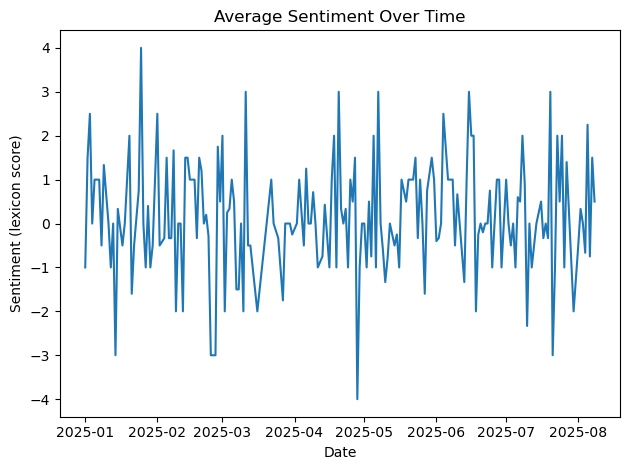

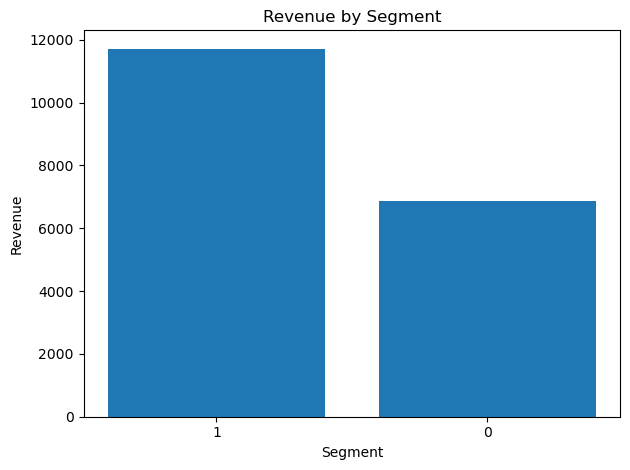

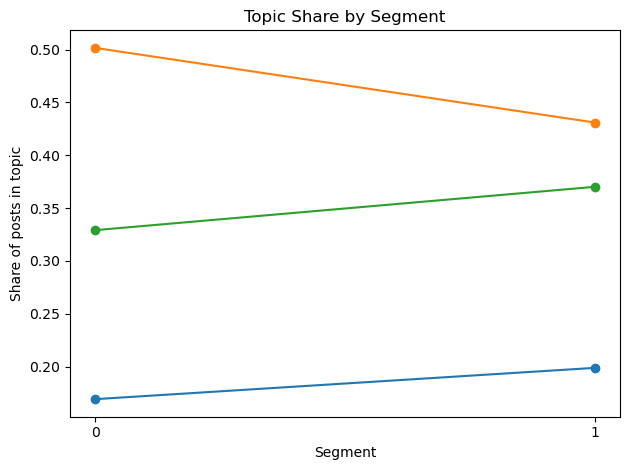

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Marketing Analysis: NLP + Segmentation (Portfolio-Ready)
- Generates synthetic feedback + channel + revenue data
- Text cleaning, LDA topic modeling, lightweight lexicon sentiment
- Customer-level TF-IDF -> SVD -> KMeans segmentation (auto-K via silhouette)
- Plots and CSV exports

Requires: pandas, numpy, scikit-learn, matplotlib
"""

import re
import string
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 0) Config
# -----------------------------
RANDOM_SEED = 42
N_RECORDS = 500
N_TOPICS = 3
SVD_COMPONENTS = 50
K_SEARCH = [2, 3, 4, 5]

OUT_RECORDS = "marketing_analysis_records.csv"
OUT_SEGMENTS = "customer_segments.csv"
OUT_TOPICS = "topic_top_words.csv"

np.random.seed(RANDOM_SEED)

# -----------------------------
# 1) Synthetic Data
# -----------------------------
start_date = datetime(2025, 1, 1)
dates = [start_date + timedelta(days=int(x)) for x in np.random.randint(0, 220, size=N_RECORDS)]
channels = np.random.choice(["email", "facebook", "instagram", "x", "web"], size=N_RECORDS, p=[0.2, 0.25, 0.25, 0.15, 0.15])
customer_ids = np.random.randint(1000, 1700, size=N_RECORDS)

positive_phrases = [
    "love the product","amazing quality","great value","fast shipping",
    "excellent support","works perfectly","very satisfied","highly recommend","superb experience","five stars"
]
negative_phrases = [
    "terrible experience","poor quality","late delivery","waste of money",
    "not worth it","does not work","very disappointed","bad support","broken item","one star"
]
neutral_phrases = [
    "received the item","as described","average quality","okay for the price",
    "fine overall","fits as expected","packaging was normal","color as shown","standard delivery","met expectations"
]
products = ["EcoBottle","FlexHeadphones","AeroWatch","ComfySocks","SmartLight"]
competitors = ["BrandX","RivalCo","AltGear"]

def make_text():
    parts = []
    r = np.random.rand()
    if r < 0.4: parts.append(np.random.choice(positive_phrases))
    elif r < 0.7: parts.append(np.random.choice(neutral_phrases))
    else: parts.append(np.random.choice(negative_phrases))
    parts.append(np.random.choice(products))
    if np.random.rand() < 0.35: parts.append(f"better than {np.random.choice(competitors)}")
    if np.random.rand() < 0.25: parts.append("discount code didn't work")
    if np.random.rand() < 0.3: parts.append("customer service was helpful")
    return " | ".join(parts)

texts = [make_text() for _ in range(N_RECORDS)]

def sentiment_proxy(t):
    s = 0
    s += sum([1 for p in positive_phrases if p in t])
    s -= sum([1 for p in negative_phrases if p in t])
    return s

sent_proxy = np.array([sentiment_proxy(t) for t in texts])
engagement = np.clip(np.random.normal(50 + 8*sent_proxy, 10, N_RECORDS).round(), 0, None)
orders = np.clip(np.random.poisson(1 + 0.15*np.maximum(sent_proxy, 0)), 0, None)
revenue = np.clip((orders * np.random.normal(35 + 4*sent_proxy, 8, N_RECORDS)).round(2), 0, None)

df = pd.DataFrame({
    "date": dates, "channel": channels, "customer_id": customer_ids,
    "text": texts, "engagement": engagement, "orders": orders, "revenue": revenue
}).sort_values("date").reset_index(drop=True)

# -----------------------------
# 2) Text Cleaning
# -----------------------------
punct = str.maketrans("", "", string.punctuation)
def clean_text(s: str) -> str:
    s = s.lower().translate(punct)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text_clean"] = df["text"].apply(clean_text)

# -----------------------------
# 3) Topic Modeling (LDA)
# -----------------------------
count_vec = CountVectorizer(min_df=5, stop_words="english")
X_counts = count_vec.fit_transform(df["text_clean"])

lda = LatentDirichletAllocation(n_components=N_TOPICS, random_state=RANDOM_SEED, max_iter=10, learning_method="batch")
topic_dist = lda.fit_transform(X_counts)

terms = np.array(count_vec.get_feature_names_out())
topic_words = {}
for k, comp in enumerate(lda.components_):
    top_idx = np.argsort(comp)[-8:][::-1]
    topic_words[k] = terms[top_idx].tolist()
df["topic"] = topic_dist.argmax(axis=1)

# -----------------------------
# 4) Lightweight Lexicon Sentiment
# -----------------------------
lexicon_pos = set([w for p in positive_phrases for w in re.findall(r"[a-z']+", p)] + ["helpful","recommend","perfectly","excellent","amazing","love","superb","satisfied"])
lexicon_neg = set([w for p in negative_phrases for w in re.findall(r"[a-z']+", p)] + ["broken","terrible","waste","late","disappointed","bad","one","star","does","not"])

def lexicon_sentiment_score(text: str) -> int:
    toks = re.findall(r"[a-z']+", text.lower())
    pos = sum(t in lexicon_pos for t in toks)
    neg = sum(t in lexicon_neg for t in toks)
    return pos - neg

df["sentiment_score"] = df["text_clean"].apply(lexicon_sentiment_score)

# -----------------------------
# 5) Customer-Level Segmentation
# -----------------------------
# TF-IDF of all customer text, reduced via SVD, plus dense features
tfidf = TfidfVectorizer(min_df=5, stop_words="english")
_ = tfidf.fit(df["text_clean"])  # fit on record-level

cust = df.groupby("customer_id").agg({
    "text_clean": " ".join,
    "sentiment_score": "mean",
    "orders": "sum",
    "revenue": "sum",
    "engagement": "mean"
}).reset_index()

X_cust = tfidf.transform(cust["text_clean"])

svd = TruncatedSVD(n_components=min(SVD_COMPONENTS, X_cust.shape[1]-1), random_state=RANDOM_SEED)
X_reduced = svd.fit_transform(X_cust)

dense = cust[["sentiment_score","orders","revenue","engagement"]].astype(float).values
scaler = StandardScaler()
dense_scaled = scaler.fit_transform(dense)

X_full = np.hstack([X_reduced, dense_scaled])

# Auto-select K via silhouette
best_k, best_score, best_labels = None, -1, None
for k in K_SEARCH:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    labels = km.fit_predict(X_full)
    # guard against degenerate labels
    if len(set(labels)) > 1:
        score = silhouette_score(X_full, labels)
        if score > best_score:
            best_k, best_score, best_labels = k, score, labels

cust["segment"] = best_labels
df = df.merge(cust[["customer_id","segment"]], on="customer_id", how="left")

print(f"[INFO] Best K for KMeans: {best_k} | Silhouette: {best_score:.3f}")

# -----------------------------
# 6) Summaries & Exports
# -----------------------------
seg_summary = cust.groupby("segment").agg(
    customers=("customer_id","count"),
    avg_sentiment=("sentiment_score","mean"),
    avg_engagement=("engagement","mean"),
    total_orders=("orders","sum"),
    revenue=("revenue","sum"),
    rev_per_cust=("revenue", lambda x: x.sum()/len(x))
).reset_index().sort_values("revenue", ascending=False)

# Save artifacts
df.to_csv(OUT_RECORDS, index=False)
cust.to_csv(OUT_SEGMENTS, index=False)
pd.DataFrame([{"topic": k, "top_words": ", ".join(v)} for k, v in topic_words.items()]).to_csv(OUT_TOPICS, index=False)

print(f"[SAVE] Records -> {OUT_RECORDS}")
print(f"[SAVE] Customer segments -> {OUT_SEGMENTS}")
print(f"[SAVE] Topic top words -> {OUT_TOPICS}")
print("\n[SEGMENT SUMMARY]\n", seg_summary.to_string(index=False))

# -----------------------------
# 7) Plots
# -----------------------------
# Sentiment over time
df_daily = df.groupby("date").agg(avg_sent=("sentiment_score","mean"),
                                  rev=("revenue","sum")).reset_index()

plt.figure()
plt.plot(df_daily["date"], df_daily["avg_sent"])
plt.title("Average Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment (lexicon score)")
plt.tight_layout()
plt.show()

# Revenue by segment
plt.figure()
plt.bar(seg_summary["segment"].astype(str), seg_summary["revenue"])
plt.title("Revenue by Segment")
plt.xlabel("Segment")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

# Topic share by segment
topic_counts = df.groupby(["segment","topic"]).size().unstack(fill_value=0)
topic_share = topic_counts.div(topic_counts.sum(axis=1), axis=0)

plt.figure()
for col in topic_share.columns:
    plt.plot(topic_share.index.astype(str), topic_share[col], marker="o")
plt.title("Topic Share by Segment")
plt.xlabel("Segment")
plt.ylabel("Share of posts in topic")
plt.tight_layout()
plt.show()
